In [1]:
import matplotlib.backends.backend_pdf
import csv
import numpy as np
import pandas as pd
# import geopandas as gpd
from IPython.display import Image
# from shapely.geometry import Point, Polygon
from math import factorial
import datetime
import time
import scipy
import scipy.signal
import os, os.path
import matplotlib

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

# from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import sys
start_time = time.time()

/Users/hn/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/remote_sensing/python/')
import remote_sensing_core as rc
import remote_sensing_plot_core as rcp

start_time = time.time()

In [3]:
SF_year = 2017
indeks = "EVI"
given_county = "Grant"
irrigated_only = True

sos_thresh = 0.5
eos_thresh = 0.5
minFinderDetla = 0.4

In [4]:
data_dir = "/Users/hn/Documents/01_research_data/remote_sensing/test_aeolus_outputs/"
f_name = "01_Regular_filledGap_Grant_SF_2017_EVI.csv"
a_df = pd.read_csv(data_dir + f_name, low_memory=False)

In [6]:
type(a_df.loc[0, 'Date'])

str

In [7]:
irrigated_a_df = rc.filter_out_nonIrrigated(a_df)
nonIrrigateda_df = rc.filter_out_Irrigated(a_df)

In [8]:
print (len(irrigated_a_df.ID.unique()))
print (len(nonIrrigateda_df.ID.unique()))

13793
3908


In [9]:
# Filter irrigated only
a_df = rc.filter_out_nonIrrigated(a_df)

In [10]:
print (len(a_df.ID.unique()))

13793


In [11]:
a_df = a_df[a_df['county']== given_county]

In [12]:
a_df = rc.filter_out_NASS(a_df) # Toss NASS
a_df = rc.filter_by_lastSurvey(a_df, year = SF_year) # filter by last survey date
a_df['SF_year'] = SF_year


In [13]:
a_df['Date'] = pd.to_datetime(a_df.Date.values).values

In [16]:
a_df.loc[0, 'Date']

Timestamp('2016-07-31 00:00:00')

In [17]:
if irrigated_only == True:
    a_df = rc.filter_out_nonIrrigated(a_df)
    output_Irr = "irrigated_only"
else:
    output_Irr = "non_irrigated_only"
    a_df = rc.filter_out_Irrigated(a_df)


In [18]:
a_df = rc.initial_clean(df = a_df, column_to_be_cleaned = indeks)
a_df.shape

(467925, 22)

In [19]:
an_EE_TS = a_df.copy()
del(a_df)


In [20]:
polygon_list = np.sort(an_EE_TS['ID'].unique())
a_poly = polygon_list[81]

In [80]:
a_poly = "100038_WSDA_SF_2017"

In [81]:
curr_field = an_EE_TS[an_EE_TS['ID']==a_poly].copy()
curr_field = curr_field[curr_field.image_year == SF_year]
print (curr_field.shape)

curr_field.sort_values(by=['image_year', 'doy'], inplace=True)

ID = curr_field['ID'].unique()[0]
plant = curr_field['CropTyp'].unique()[0]
plant = plant.replace("/", "_")
plant = plant.replace(",", "_")
plant = plant.replace(" ", "_")
plant = plant.replace("__", "_")

county = given_county

(36, 22)


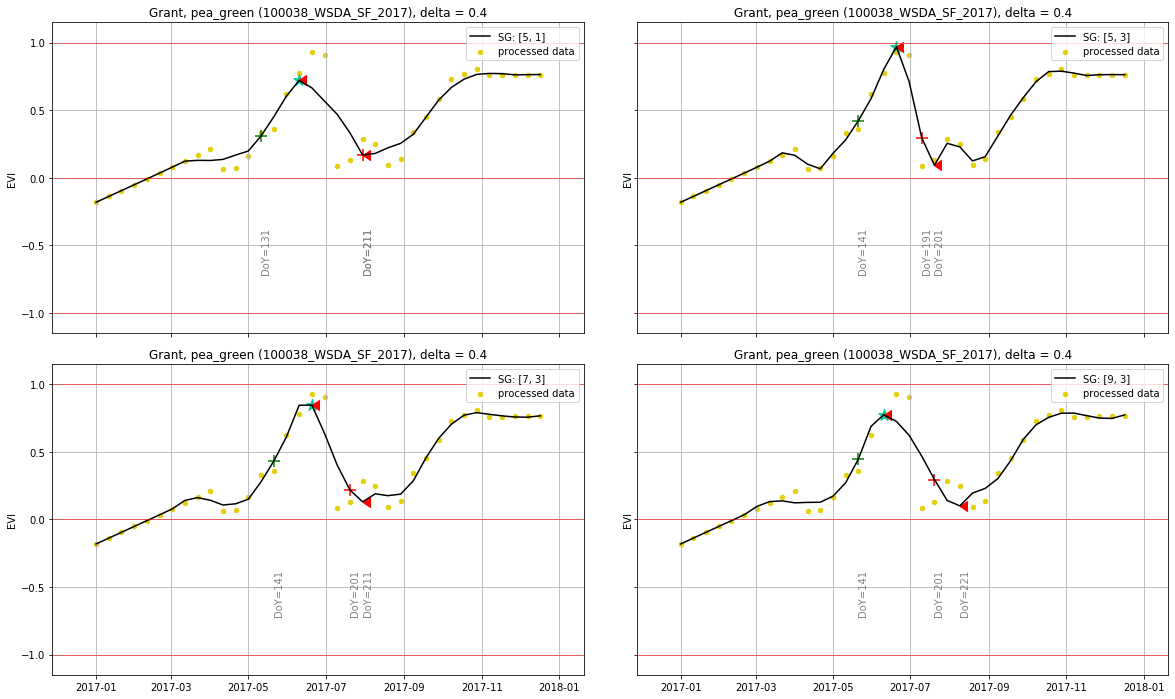

In [82]:
fig, axs = plt.subplots(2, 2, figsize=(20,12),
                sharex='col', sharey='row',
                gridspec_kw={'hspace': 0.1, 'wspace': .1});

(ax1, ax2), (ax3, ax4) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True); ax4.grid(True);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = curr_field, 
                                           idx=indeks, 
                                           SG_params=[5, 1], 
                                           SFYr = SF_year, ax=ax1, deltA= minFinderDetla,
                                           onset_cut = sos_thresh, 
                                           offset_cut = eos_thresh);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = curr_field, 
                                           idx=indeks, SG_params=[5, 3], 
                                           SFYr=SF_year, ax=ax2, deltA=minFinderDetla,
                                           onset_cut = sos_thresh, 
                                           offset_cut = eos_thresh); 

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = curr_field, 
                                           idx = indeks, SG_params=[7, 3],
                                           SFYr = SF_year, ax=ax3, deltA=minFinderDetla,
                                           onset_cut = sos_thresh, 
                                           offset_cut = eos_thresh);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = curr_field, 
                                           idx=indeks, SG_params=[9, 3],
                                           SFYr=SF_year, ax=ax4, deltA=minFinderDetla,
                                           onset_cut = sos_thresh, 
                                           offset_cut = eos_thresh)

plot_path = "/Users/hn/Desktop/Kirti_investigation/"
fig_name = plot_path + ID + '.png'
plt.savefig(fname = fig_name, dpi=600, bbox_inches='tight')

### Test SG_1yr_panels_clean_sciPy_My_Peaks_SOS(.)

In [88]:
dataAB = curr_field
idx=indeks
SG_params=[5, 3]
SFYr = SF_year
ax=ax1
deltA= minFinderDetla
onset_cut = sos_thresh
offset_cut = eos_thresh

crr_fld = dataAB.copy()
if (not("human_system_start_time" in list(crr_fld.columns))):
    crr_fld = rc.add_human_start_time(crr_fld)

eleven_colors = ["gray", "lightcoral", "red", "peru",
             "darkorange", "gold", "olive", "green",
             "blue", "violet", "deepskyblue"]

plant = crr_fld['CropTyp'].unique()[0]
# Take care of names, replace "/" and "," and " " by "_"
plant = plant.replace("/", "_")
plant = plant.replace(",", "_")
plant = plant.replace(" ", "_")
plant = plant.replace("__", "_")

county = crr_fld['county'].unique()[0]
ID = crr_fld['ID'].unique()[0]

y = crr_fld[idx].copy()


window_len = SG_params[0]
poly_order = SG_params[1]

SG_pred = scipy.signal.savgol_filter(y, window_length= window_len, polyorder=poly_order)

In [89]:
if len(crr_fld['image_year'].unique()) == 2:
    X = rc.extract_XValues_of_2Yrs_TS(crr_fld, SF_yr = SFYr)
elif len(crr_fld['image_year'].unique()) == 1:
    X = crr_fld['doy']

d = {'DoY': X, 'Date': pd.to_datetime(crr_fld.human_system_start_time.values).values}
date_df = pd.DataFrame(data=d)

min_val_for_being_peak = 0.5

In [90]:
crr_fld [idx] = SG_pred
crr_fld = rc.addToDF_SOS_EOS_White(pd_TS = crr_fld, 
                                   VegIdx = idx, 
                                   onset_thresh = onset_cut, 
                                   offset_thresh = offset_cut)

In [91]:
SOS_tb = crr_fld[crr_fld['SOS'] != 0]
EOS_tb = crr_fld[crr_fld['EOS'] != 0]

y_orchard = crr_fld[crr_fld['doy']>= 122]
y_orchard = y_orchard[y_orchard['doy'] <=305]
print (max(y_orchard["EVI"]) - min(y_orchard["EVI"]))

0.8766051288648362


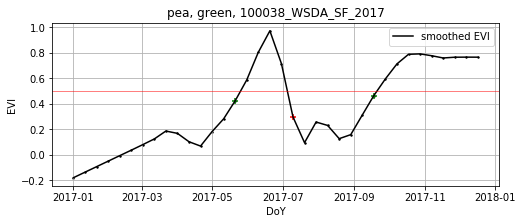

In [92]:
fig, ax = plt.subplots(figsize=(8,3));
plot_title = curr_field.CropTyp.unique()[0] + ", " + crr_fld.ID.unique()[0]

ax.plot(curr_field['Date'], SG_pred, c='k', label="smoothed EVI")
ax.scatter(curr_field['Date'], SG_pred, marker='o', s=2, c='k')

ax.scatter(SOS_tb['Date'], SOS_tb['SOS'], marker='+', s=40, c='g')
ax.scatter(EOS_tb['Date'], EOS_tb['EOS'], marker='+', s=40, c='r')


ax.axhline(0.5 , color = 'r', linewidth=.5)
ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

plot_path = "/Users/hn/Desktop/Kirti_investigation/"
fig_name = plot_path + ID + "_after_null_" + str(SG_params[0]) + str(SG_params[1]) + "_" + \
           str((EOS_tb.Date.iloc[0] - SOS_tb.Date.iloc[0]).days) + 'days.png'
plt.savefig(fname = fig_name, dpi=600, bbox_inches='tight')

In [93]:
# crr_fld = rc.Null_SOS_EOS_by_DoYDiff(pd_TS = crr_fld, min_season_length=60)

### Test crr_fld = rc.Null_SOS_EOS_by_DoYDiff(pd_TS = crr_fld, min_season_length=60)

In [ ]:
pd_TS = crr_fld
min_season_length=60

In [ ]:
pd_TS_DoYDiff = pd_TS.copy()

# find indexes of SOS and EOS
SOS_indexes = pd_TS_DoYDiff.index[pd_TS_DoYDiff['SOS'] != 0].tolist()
EOS_indexes = pd_TS_DoYDiff.index[pd_TS_DoYDiff['EOS'] != 0].tolist()

In [ ]:
SOS_indexes

In [ ]:
EOS_indexes

In [ ]:
SOS_pointer = SOS_indexes[-1]
EOS_pointer = EOS_indexes[-1]

In [ ]:
(pd_TS_DoYDiff.loc[EOS_pointer, 'Date'] < pd_TS_DoYDiff.loc[SOS_pointer, 'Date'])

In [ ]:
SOS_pointer

In [ ]:
EOS_pointer

In [ ]:
SOS_indexes

In [ ]:
EOS_pointer

In [ ]:
pd_TS_DoYDiff.loc[SOS_indexes, 'EVI']

In [ ]:
# pd_TS_DoYDiff

In [ ]:
fig, ax = plt.subplots(figsize=(8,3));
plot_title = curr_field.CropTyp.unique()[0]

ax.plot(curr_field['Date'], curr_field['EVI'], c='k', label="EVI")
ax.scatter(curr_field['Date'], curr_field['EVI'], marker='o', s=2, c='k')

ax.plot(curr_field['Date'], SG_pred, c='c', label="smoothed EVI")
ax.scatter(curr_field['Date'], SG_pred, marker='o', s=2, c='c')

ax.scatter(pd_TS_DoYDiff.loc[SOS_indexes, 'Date'].values, 
           pd_TS_DoYDiff.loc[SOS_indexes, 'EVI'].values, 
           marker='+', s=20, c='c')

ax.scatter(pd_TS_DoYDiff.loc[EOS_indexes, 'Date'].values, 
           pd_TS_DoYDiff.loc[EOS_indexes, 'EVI'].values, 
           marker='+', s=20, c='c')


ax.axhline(0.5 , color = 'r', linewidth=.5)
ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

# plot_path = "/Users/hn/Desktop/"
# fig_name = plot_path + 'EVI_VS_EVIratio.png'
# plt.savefig(fname = fig_name, dpi=600, bbox_inches='tight')

In [ ]:
pd_TS_DoYDiff.loc[SOS_indexes, 'EVI'].values

#### It seems EOS should exist, so, lets examine the function addToDF_SOS_EOS_White(.) now.


In [ ]:
pd_TS = crr_fld
VegIdx = idx
onset_thresh = onset_cut
offset_thresh = offset_cut

In [ ]:
pandaFrame = pd_TS.copy()

VegIdx_min = pandaFrame[VegIdx].min()
VegIdx_max = pandaFrame[VegIdx].max()
VegRange = VegIdx_max - VegIdx_min + sys.float_info.epsilon

colName = VegIdx + "_ratio"
pandaFrame[colName] = (pandaFrame[VegIdx] - VegIdx_min) / VegRange

In [ ]:
VegRange

In [ ]:
fig, ax = plt.subplots(figsize=(8,3));
plot_title = curr_field.CropTyp.unique()[0]

ax.plot(curr_field['Date'], curr_field['EVI'], c='k', label="EVI")
ax.scatter(curr_field['Date'], curr_field['EVI'], marker='o', s=2, c='k')

ax.plot(curr_field['Date'], SG_pred, c='c', label="smoothed EVI")
ax.scatter(curr_field['Date'], SG_pred, marker='o', s=2, c='c')


ax.plot(pandaFrame['Date'], pandaFrame[colName], c='r', label = "EVI ratio")
ax.scatter(pandaFrame['Date'], pandaFrame[colName], marker='o', s=2, c='r')

ax.axhline(0.5 , color = 'r', linewidth=.5)
ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

plot_path = "/Users/hn/Desktop/"
fig_name = plot_path + 'EVI_VS_EVIratio.png'
plt.savefig(fname = fig_name, dpi=600, bbox_inches='tight')

In [ ]:
curr_field.columns